<a href="https://colab.research.google.com/github/khammersmith17/c598DeepLearning/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Section 0:
1. Fixing package depedency issue in the runtime
2. Printing all package versions in the runtime

In [ ]:
%%capture
!pip install sympy==1.12.0

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import os
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch.nn.functional as F
import torchvision
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import json
from time import perf_counter

In [ ]:
print(f"numpy version: {np.__version__}")
print(f"pandas version: {pd.__version__}")
print(f"torch version: {torch.__version__}")
print(f"torchvision version: {torchvision.__version__}")
print(f"PIL version: {Image.__version__}")
print(f"sklearn version: {sklearn.__version__}")
print(f"seaborn version: {sns.__version__}")
print(f"matplotlib version: {matplotlib.__version__}")

numpy version: 2.0.2
pandas version: 2.2.2
torch version: 2.6.0+cu124
torchvision version: 0.21.0+cu124
PIL version: 11.1.0
sklearn version: 1.6.1
seaborn version: 0.13.2
matplotlib version: 3.10.0


In [ ]:
# Load MIMIC-CXR image metadata and split info
metadata = pd.read_csv("mimic-cxr-2.0.0-metadata.csv.gz")
split = pd.read_csv("mimic-cxr-2.0.0-split.csv.gz")

# Load MIMIC-IV patient and admission data
patients = pd.read_csv("patients.csv")
admissions = pd.read_csv("admissions.csv")

# Use anchor_age as age and ethnicity as race
# Use first admission per patient to get the ethnicity
first_adm = admissions.sort_values("admittime").drop_duplicates("subject_id", keep="first")

In [ ]:
demo = pd.merge(
    patients[["subject_id", "gender", "anchor_age"]],
    first_adm[["subject_id", "ethnicity"]],
    on="subject_id", how="left"
)

# Rename fields for consistency
demo = demo.rename(columns={
    "gender": "sex",
    "anchor_age": "age",
    "ethnicity": "race"
})

# Merge demographic info with image metadata
meta_demo = pd.merge(metadata, demo, on="subject_id", how="left")

# Merge with train/val/test split info
meta_all = pd.merge(meta_demo, split, on=["subject_id", "study_id", "dicom_id"], how="left")

# Generate CheXpert-style image path
meta_all["path"] = meta_all.apply(
    lambda row: f"p{str(row.subject_id)[:2]}/p{row.subject_id}/s{row.study_id}/{row.dicom_id}.jpg", axis=1
)

final_df = meta_all[["path", "subject_id", "study_id", "sex", "age", "race", "split"]]

# persisting csv
final_df.to_csv("mimic_metadata.csv", index=False)

Here is where we will actually generate the synthetic CheXpert dataset.

In [ ]:
df = pd.read_csv("mimic_metadata.csv")

# Step 1: Sample 20% as synthetic CheXpert dataset
chex_synth = df.sample(frac=0.2, random_state=42).copy()

# Step 2: Assign labels using CheXpert-like prevalence
label_prevalence = {
    "No Finding": 0.10,
    "Fracture": 0.04,
    "Pneumothorax": 0.09
}

for label, p in label_prevalence.items():
    chex_synth[label] = np.random.binomial(n=1, p=p, size=len(chex_synth))

# Step 3: Inject uncertainty (15% chance of converting 1 or 0 to 0.5)
def add_uncertainty(col):
    uncertain = np.random.rand(len(col)) < 0.15
    col[uncertain] = 0.5
    return col

chex_synth["No Finding"] = add_uncertainty(chex_synth["No Finding"].astype(float))
chex_synth["Fracture"] = add_uncertainty(chex_synth["Fracture"].astype(float))
chex_synth["Pneumothorax"] = add_uncertainty(chex_synth["Pneumothorax"].astype(float))

# Step 4: Save CSV
chex_synth_out = chex_synth[["path", "No Finding", "Fracture", "Pneumothorax", "sex", "age", "race"]]
chex_synth_out.to_csv("synthetic_chexpert.csv", index=False)

Using the path in the synthetic CheXpert dataset, create a random greyscale JPG image based on suggestion from LLM for a synthetic MINIC_CXR_JPG dataset.

In [ ]:
IMAGE_SIZE = (224, 224)
BASE_DIR = "mimic_images"
chex_synth_out = pd.read_csv("synthetic_chexpert.csv")
subset_size = 0.33
# using a subset of the dataset due to time limit on runtime, starting with 1/3
chex_synth_out_subset = chex_synth_out.iloc[:int(chex_synth_out.shape[0] * subset_size),:]
chex_synth_out_subset.to_csv("synthetic_chexpert_subset.csv", index=False, header=True)

for _, row in chex_synth_out_subset.iterrows():

  # create the dir to match the directory structure of the actual dataset
  dir = os.path.join(BASE_DIR, *row.path.split("/")[:-1])
  os.makedirs(dir, exist_ok=True)

  # a random greyscale image with the same size as what the researchers scale the images to
  img_array = np.random.randint(0, 256, size=IMAGE_SIZE, dtype=np.uint8)
  img = Image.fromarray(img_array)

  img.save(f"{BASE_DIR}/{row.path}")

Generating some visuals to look across the different demographic axis we have available: gender, race, age

In [ ]:
# Config
CSV_PATH = "synthetic_chexpert.csv"
OUTPUT_DIR = "eda_outputs"
LABELS = ["No Finding", "Fracture", "Pneumothorax"]

# Load data
chex_synth_out = pd.read_csv(CSV_PATH)
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Label distribution plots
for label in LABELS:
    plt.figure(figsize=(6,4))
    chex_synth_out[label].value_counts().sort_index().plot(kind="bar", color="skyblue")
    plt.title(f"Distribution of {label} Labels")
    plt.xticks([0, 1, 2], ['0 (Negative)', '0.5 (Uncertain)', '1 (Positive)'], rotation=0)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIR}/{label}_distribution.png")
    plt.close()

# Age group bucketing
chex_synth_out["age_group"] = pd.cut(chex_synth_out["age"], bins=[0, 40, 60, 80, 120], labels=["<40", "40–60", "60–80", "80+"])

# Mean label prevalence by sex
plt.figure(figsize=(8,5))
chex_synth_out.groupby("sex")[LABELS].mean().plot(kind="bar")
plt.title("Average Label Prevalence by Sex")
plt.ylabel("Prevalence")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/prevalence_by_sex.png")
plt.close()

# Mean label prevalence by age group
plt.figure(figsize=(8,5))
chex_synth_out.groupby("age_group")[LABELS].mean().plot(kind="bar")
plt.title("Average Label Prevalence by Age Group")
plt.ylabel("Prevalence")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/prevalence_by_age.png")
plt.close()

# Mean label prevalence by race
plt.figure(figsize=(10,5))
chex_synth_out.groupby("race")[LABELS].mean().plot(kind="bar")
plt.title("Average Label Prevalence by Race")
plt.ylabel("Prevalence")
plt.tight_layout()
plt.savefig(f"{OUTPUT_DIR}/prevalence_by_race.png")
plt.close()

<ipython-input-6-13bb0b0ff35e>:39: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  chex_synth_out.groupby("age_group")[LABELS].mean().plot(kind="bar")


<Figure size 800x500 with 0 Axes>

<Figure size 800x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

Definig the dataset class and the transform to be applied on the x-ray images

In [ ]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# transform for dataset processing
def get_transforms(train=True, img_size=224):
    if train:
        return transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(10),
            transforms.RandomResizedCrop(img_size, scale=(0.8, 1.0)),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((img_size, img_size)),
            transforms.ToTensor(),
            transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ])


class CXRDataset(Dataset):
    def __init__(self, csv_path, img_root, labels=["No Finding", "Fracture", "Pneumothorax"],
                 img_size=224, train=True, uncertainty_strategy="zero"):
        """
        uncertainty_strategy: "zero" (convert 0.5 -> 0), "one" (convert 0.5 -> 1), "ignore" (mask label)
        """
        self.data = pd.read_csv(csv_path)
        self.labels = labels
        self.img_root = img_root
        self.transforms = get_transforms(train, img_size)
        self.uncertainty_strategy = uncertainty_strategy

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.img_root, row["path"])
        image = Image.open(img_path).convert("RGB")
        image = self.transforms(image)

        label = torch.tensor(row[self.labels].values.astype(np.float32), dtype=torch.float32)

        if self.uncertainty_strategy == "zero":
            label[label == 0.5] = 0
        elif self.uncertainty_strategy == "one":
            label[label == 0.5] = 1
        elif self.uncertainty_strategy == "ignore":
            # Optionally, add a mask for missing labels if needed
            pass
        # applying an encoding to incorporate all three groups
        race = 0 if row['race'] == "WHITE" else 1
        sex = 0 if row['sex'] == "M" else 1
        age_group = int(row['age'] >= 60)
        group_id = race * 4 + sex * 2 + age_group

        return image, label, torch.tensor(group_id, dtype=torch.long)

In [ ]:
# using subset the images were generated on
train_csv = "synthetic_chexpert_subset.csv"
img_root = "mimic_images"

# training dataset/loader
train_dataset = CXRDataset(csv_path=train_csv, img_root=img_root, train=True)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4)

# validation dataset/loader
val_dataset = CXRDataset(csv_path=train_csv, img_root=img_root, train=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Section 2: Model
1. Define the model
2. The model is an augmented version of DenseNet-121
3. Load the DenseNet-121 pretrained on ImageNet Data
4. Replace the final classifier layer with a fully connected layer

In [ ]:
class DenseNet121Classifier(nn.Module):
  """
  The base is the DenseNet-121.
  The classifier layer is replaced with a fully connected layer.
  Also, a dropout layer is added for regularization.
  """
  def __init__(self, dropout_rate=0.2, num_classes=3):
      super(DenseNet121Classifier, self).__init__()
      self.backbone = models.densenet121(pretrained=True)
      num_ftrs = self.backbone.classifier.in_features
      self.backbone.classifier = nn.Sequential(
          nn.Linear(num_ftrs, 384),
          nn.ReLU(),
          nn.Dropout(dropout_rate),
          nn.Linear(384, num_classes)
      )

  def forward(self, x):
      return self.backbone(x)

In [ ]:
def train_model(train_loader, val_loader, epochs=10, lr=1e-4, lambda_fairness=1.0, mu=0.1, device='cuda') -> pd.DataFrame:
  """
  trains a new model for every different fairness criteria
  returns a dataframe with the results for each fairness criteria
  new model is initialized with random weights for each fairness criteria
  """
  methods = ['ERM', 'BalancedERM', 'MMDMatch', 'MeanMatch', 'GroupDRO', 'ARL', 'FairALM']
  if os.path.exists("train-results.json"):
    # if a previous attempt failed due to some error
    # we pick up where we left off
    with open("train-results.json", "r") as f:
      method_results = json.load(f)
      methods_remaining = [method for method in methods if method not in method_results.keys()]
      methods = methods_remaining
  else:
    method_results = {'Fairness Method': [], 'Worst-Group AUROC': [], 'Overall AUROC': []}

  for method in methods:
    print(f"Starting method: {method}")
    model = DenseNet121Classifier().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.BCEWithLogitsLoss()
    lambda_fair = lambda_fairness
    epoch_times = []
    for epoch in range(epochs):
      start = perf_counter()
      print(f"starting epoch: {epoch + 1} for method: {method}")
      model.train()
      total_loss = 0

      for i, batch in enumerate(train_loader):
        assert len(batch) == 3, "no group in batch"
        x = batch[0].to(device)
        y = batch[1].float().to(device)
        group = batch[2].to(device)

        optimizer.zero_grad()
        logits = model(x).squeeze(1)

        base_loss = criterion(logits, y)
        loss = base_loss

        # --- Apply Fairness Techniques ---
        if method in ['MMDMatch', 'MeanMatch']:
          fairness_penalty = compute_fairness_penalty(logits, y, group, method)
          loss = base_loss + lambda_fairness * fairness_penalty

        elif method == 'GroupDRO':
          group_losses = compute_loss_per_group(logits, y, group)
          loss = group_losses.max()

        elif method == 'ARL':
          sample_weights = adversarial_reweight(logits)
          loss = (sample_weights * F.binary_cross_entropy_with_logits(logits, y, reduction='none')).mean()

        elif method == 'FairALM':
          fairness_penalty = compute_fairalm_penalty(logits, y, group)
          loss = base_loss + lambda_fair * fairness_penalty + mu * (fairness_penalty ** 2)
          lambda_fair = lambda_fair + mu * fairness_penalty.item()

        loss.backward()
        optimizer.step()

        total_loss += loss.item()
      epoch_times.append(perf_counter() - start)
    auc, worst_group_auc = evaluate_model(model, val_loader, device)
    method_results.get('Fairness Method').append(method)
    method_results.get('Worst-Group AUROC').append(worst_group_auc)
    method_results.get('Overall AUROC').append(auc)
    with open("train-results.json", "w") as f:
      # saving for every method in case training gets interrupted
      # either from a training timeout or a runtime error
      json.dump(method_results, f)
    print(f"Average epoch time: {sum(epoch_times) / epochs} for method: {method}")


  return method_results

def adversarial_reweight(logits):
  return torch.ones_like(logits)

def compute_fairness_penalty(logits, y, groups, method):
  """
  Compute fairness penalty based on method.
  Inputs:
      logits: Tensor (batch_size,)
      y: Tensor (batch_size,)
      groups: Tensor (batch_size,)
      method_name: str ("MeanMatch", "MMDMatch")
  Returns:
      fairness_penalty: scalar tensor
  """

  if method == 'MeanMatch':
      # MeanMatch: match average predicted probability across groups
      unique_groups = torch.unique(groups)
      group_means = []

      for g in unique_groups:
          mask = (groups == g)
          if mask.sum() > 0:
              group_mean = torch.sigmoid(logits[mask]).mean()
              group_means.append(group_mean)

      penalty = torch.var(torch.stack(group_means))  # Variance between group means
      return penalty

  elif method == 'MMDMatch':
      # MMDMatch: Maximum Mean Discrepancy between groups
      unique_groups = torch.unique(groups)
      group_preds = []

      for g in unique_groups:
          mask = (groups == g)
          if mask.sum() > 0:
              group_pred = torch.sigmoid(logits[mask])
              group_preds.append(group_pred)

      if len(group_preds) < 2:
          return torch.tensor(0.0, device=logits.device)

      # Compute MMD between each pair
      penalty = 0
      for i in range(len(group_preds)):
          for j in range(i + 1, len(group_preds)):
              penalty += maximum_mean_discrepancy(group_preds[i], group_preds[j])

      return penalty

  else:
      raise ValueError(f"Unsupported fairness method: {method}")


def compute_loss_per_group(logits, y, group):
  unique_groups = group.unique()
  group_losses = []
  for g in unique_groups:
      mask = (group == g)
      if mask.sum() > 0:
          group_loss = F.binary_cross_entropy_with_logits(logits[mask], y[mask], reduction='mean')
          group_losses.append(group_loss)
  return torch.stack(group_losses)

def maximum_mean_discrepancy(x, y):
  x = x.view(-1, 1)
  y = y.view(-1, 1)
  xx = torch.cdist(x, x, p=2)
  yy = torch.cdist(y, y, p=2)
  xy = torch.cdist(x, y, p=2)
  XX = torch.exp(-0.5 * xx ** 2)
  YY = torch.exp(-0.5 * yy ** 2)
  XY = torch.exp(-0.5 * xy ** 2)
  return XX.mean() + YY.mean() - 2 * XY.mean()

def compute_fairalm_penalty(logits, labels, groups, threshold=0.5):
  probs = torch.sigmoid(logits)
  preds = (probs > threshold).float()

  unique_groups = torch.unique(groups)
  tpr_list = []
  fpr_list = []

  for g in unique_groups:
      mask = (groups == g)
      if mask.sum() == 0:
          continue
      group_labels = labels[mask]
      group_preds = preds[mask]

      TP = (group_preds * group_labels).sum()
      FP = (group_preds * (1 - group_labels)).sum()
      FN = ((1 - group_preds) * group_labels).sum()
      TN = ((1 - group_preds) * (1 - group_labels)).sum()

      tpr = TP / (TP + FN + 1e-6)
      fpr = FP / (FP + TN + 1e-6)

      tpr_list.append(tpr)
      fpr_list.append(fpr)

  tpr_violation = torch.var(torch.stack(tpr_list))
  fpr_violation = torch.var(torch.stack(fpr_list))

  return tpr_violation + fpr_violation


def evaluate_model(model, val_loader, device='cuda'):
    model.eval()
    preds, labels, groups = [], [], []

    with torch.no_grad():
        for batch in val_loader:
            x = batch[0].to(device)
            y = batch[1].cpu().numpy()
            group = batch[2].cpu().numpy()
            logits = model(x).squeeze(1)
            probas = torch.sigmoid(logits).cpu().numpy()

            preds.extend(probas)
            labels.extend(y)
            group = [int(g) if not isinstance(g, (int, float)) else g for g in group]
            groups.extend(group)

    overall_auc = roc_auc_score(labels, preds)

    df = pd.DataFrame({'label': labels, 'pred': preds, 'group': groups})
    all_groups = df["group"].unique()
    print(all_groups)
    group_aurocs = []
    for g in all_groups:
        group_df = df[df['group'] == g]
        auc = roc_auc_score(group_df['label'].to_numpy()[0], group_df['pred'].to_numpy()[0])
        if auc == 0 or np.isnan(auc):
          continue
        group_aurocs.append(auc)

    worst_group_auc = min(group_aurocs)
    return overall_auc, worst_group_auc


def display_results(results_df):
    print("\nFairness Method Comparison:")
    print(results_df)

    # Plot
    plt.figure(figsize=(12, 6))
    bar_width = 0.35
    x = range(len(results_df))

    plt.bar([i - bar_width/2 for i in x], results_df['Overall AUROC'], width=bar_width, label='Overall AUROC')
    plt.bar([i + bar_width/2 for i in x], results_df['Worst-Group AUROC'], width=bar_width, label='Worst-Group AUROC')

    plt.ylabel('AUROC')
    plt.xlabel('Fairness Method')
    plt.title('Overall vs Worst-Group AUROC by Fairness Method')
    plt.xticks(ticks=x, labels=results_df['Fairness Method'], rotation=45)
    plt.legend()
    plt.grid(axis='y')
    plt.tight_layout()
    plt.savefig("results_real.png")
    plt.show()


In [ ]:
import warnings
warnings.filterwarnings("ignore")
training_results_df = train_model(train_loader=train_loader, val_loader=val_loader)

Starting method: ERM


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 72.0MB/s]


starting epoch: 1 for method: ERM
starting epoch: 2 for method: ERM
starting epoch: 3 for method: ERM
starting epoch: 4 for method: ERM
starting epoch: 5 for method: ERM
starting epoch: 6 for method: ERM
starting epoch: 7 for method: ERM
starting epoch: 8 for method: ERM
starting epoch: 9 for method: ERM
starting epoch: 10 for method: ERM
[0 3 1 5 6 4 2 7]
Average epoch time: 257.1488373676999 for method: ERM
Starting method: BalancedERM
starting epoch: 1 for method: BalancedERM
starting epoch: 2 for method: BalancedERM
starting epoch: 3 for method: BalancedERM
starting epoch: 4 for method: BalancedERM
starting epoch: 5 for method: BalancedERM
starting epoch: 6 for method: BalancedERM
starting epoch: 7 for method: BalancedERM
starting epoch: 8 for method: BalancedERM
starting epoch: 9 for method: BalancedERM
starting epoch: 10 for method: BalancedERM
[0 3 1 5 6 4 2 7]
Average epoch time: 256.9502639842 for method: BalancedERM
Starting method: MMDMatch
starting epoch: 1 for method: MMDM


Fairness Method Comparison:
  Fairness Method  Worst-Group AUROC  Overall AUROC
0             ERM                0.5       0.516841
1     BalancedERM                0.5       0.519121
2        MMDMatch                0.5       0.524343
3       MeanMatch                0.5       0.518907
4        GroupDRO                0.5       0.513338
5             ARL                0.5       0.509874
6         FairALM                0.5       0.518453


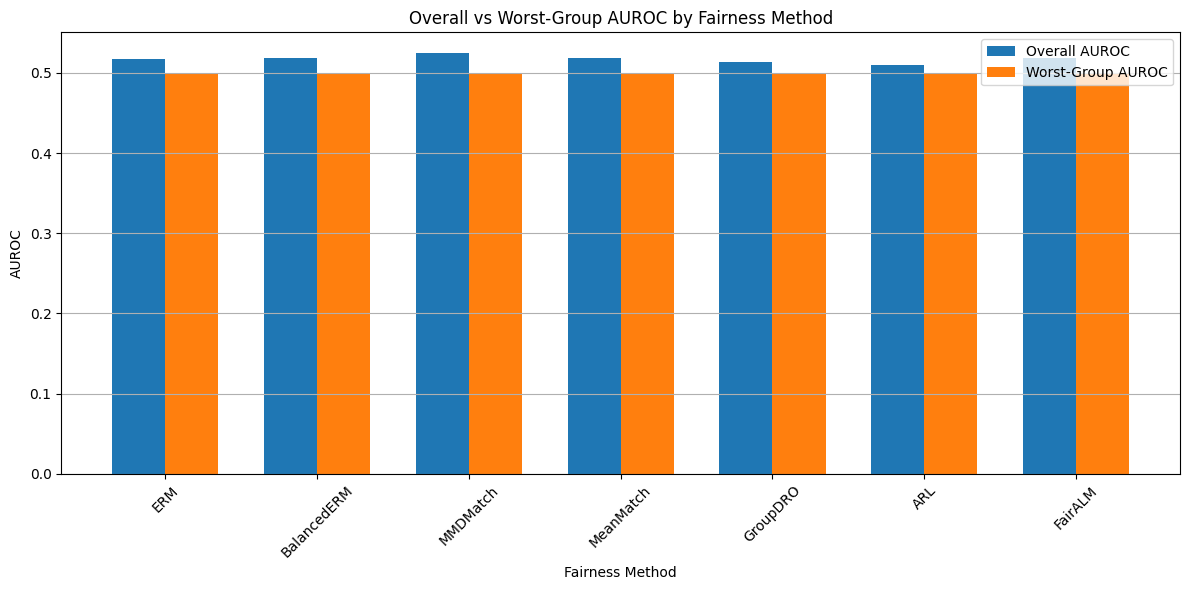

In [ ]:
display_df = pd.DataFrame(training_results_df)
display_results(display_df)

In [ ]:
# using html to generate a table of results
display_df_html = display_df.to_html(index=False)
with open("results_real.html", "w") as f:
  f.write(display_df_html)